In [1]:
import warnings
import pandas as pd
import geopandas as gpd
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '8g')
SparkContext.setSystemProperty('spark.executor.cores', '4')
SparkContext.setSystemProperty('spark.cores.max', '4')
SparkContext.setSystemProperty("spark.driver.memory",'8g')

warnings.filterwarnings("ignore")
sc = SparkContext("local", "Data Analysis")
spark = SparkSession.builder.getOrCreate()
spark

In [2]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

### Files

In [3]:
ytx_2018_sdf = spark.read.parquet('../preprocessed_data/ytx_2018_pre.parquet/')

### Taxi Zones

In [4]:
# sf stands for shape file
zone_sf = gpd.read_file("../raw_data/taxi_zones/taxi_zones.shp")
zone_pdf = pd.read_csv("../raw_data/taxi_zones/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
# Please attribute this if you are using it
zone_sf['geometry'] = zone_sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: DLL load failed: The specified module could not be found.

## Geospatial Analysis

### YTX Number of Trips by time in 2018

In [ ]:
ytx_2018_sdf = ytx_2018_sdf.withColumn('hour', F.hour('tpep_pickup_datetime'))

In [ ]:
trips_per_hour_sdf = ytx_2018_sdf.groupBy('hour').agg(F.count('hour')).withColumnRenamed('count(hour)', 'number_of_trips')

In [ ]:
trips_per_hour_pdf = trips_per_hour_sdf.toPandas()
six_to_fourteen = trips_per_hour_pdf.loc[trips_per_hour_pdf['hour'] > 5].loc[trips_per_hour_pdf['hour'] < 15]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5), gridspec_kw={'width_ratios': [2, 1]})
sns.barplot(x = 'hour', y = 'number_of_trips', ax = ax1, data = trips_per_hour_pdf)
sns.barplot(x = 'hour', y = 'number_of_trips', ax = ax2, data = six_to_fourteen)

fig.suptitle("Total Yellow Taxi trips in 2018", fontsize=18)

ax1.set_title('24 Hour', fontsize = 15)
ax1.set_xlabel("Hour", fontsize = 15)
ax1.set_ylabel("Number of Trips (x 1e^6)", fontsize = 12)

ax2.set_title('Hour 6 to 14', fontsize = 15)
ax2.set_xlabel("Hour", fontsize = 15)
ax2.set_ylabel("Number of Trips")

fig.tight_layout()
fig.savefig("../plots/YTX_Total_Trips.png")

### Pickup Hotspots and Dropoff Hotspots

In [ ]:
pickup_sdf = ytx_2018_sdf.groupBy('PULocationID') \
                         .agg(F.count('PULocationID'), F.sum('tip_amount'), F.mean('tip_amount'), 
                              F.sum('fare_amount'), F.mean('air_temp_celsius'),
                              F.mean('wind_speed_mps'), F.mean('hour'))

dropoff_sdf = ytx_2018_sdf.groupBy('DOLocationID') \
                         .agg(F.count('DOLocationID'), F.sum('tip_amount'), F.mean('tip_amount'), 
                              F.sum('fare_amount'), F.mean('air_temp_celsius'),
                              F.mean('wind_speed_mps'), F.mean('hour'))


In [ ]:
pickup_pdf = pickup_sdf.toPandas()
dropoff_pdf = dropoff_sdf.toPandas()

In [ ]:
pickup_pdf

In [ ]:
pickup_gdf = gpd.GeoDataFrame(pd.merge(pickup_pdf, zone_sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
dropoff_gdf = gpd.GeoDataFrame(pd.merge(dropoff_pdf, zone_sf, left_on='DOLocationID', right_on='LocationID')).drop('DOLocationID',axis=1)

In [ ]:
pickup_geoJSON = pickup_gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()
dropoff_geoJSON = dropoff_gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

In [ ]:
pickup_gdf

### Region active hours

In [ ]:
import folium

m_hour = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

folium.Choropleth(
    geo_data = pickup_geoJSON,
    name = 'choropleth',
    data = pickup_gdf,
    columns = ['LocationID','avg(hour)'],
    key_on = 'properties.LocationID', 
    fill_color = 'YlGnBu', 
    fill_opacity='1',
    line_opacity='0.5',
    legend_name = 'Number of Pickup Trips' 
).add_to(m_hour)

# Add Interaction to the map from here 
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    pickup_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zone', 'avg(hour)'],
        aliases=['Zone: ', 'Active Hours: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m_hour.add_child(NIL)
m_hour.keep_in_front(NIL)
folium.LayerControl().add_to(m_hour)
# to here

m_hour.save('../plots/most_active_hours.html')
m_hour

### Most Pickup

In [ ]:
m_pickup = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data = pickup_geoJSON, # geoJSON 
    name = 'choropleth', # name of plot
    data = pickup_gdf, # data source
    columns = ['LocationID','count(PULocationID)'], # the columns required
    key_on = 'properties.LocationID', # this is from the geoJSON's properties
    fill_color = 'YlGnBu', # color scheme
    fill_opacity='1',
    line_opacity='0.5',
    legend_name = 'Number of Pickup Trips' # legend title
).add_to(m_pickup)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    pickup_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zone', 'count(PULocationID)'],
        aliases=['Zone: ', 'Number of Trips: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m_pickup.add_child(NIL)
m_pickup.keep_in_front(NIL)
folium.LayerControl().add_to(m_pickup)

m_pickup.save('../plots/most_pickup.html')
m_pickup

### Highest Average Tip amount

In [ ]:
m_avgtip = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data = pickup_geoJSON, # geoJSON 
    name = 'choropleth', # name of plot
    data = pickup_gdf, # data source
    columns = ['LocationID','avg(tip_amount)'], # the columns required
    key_on = 'properties.LocationID', # this is from the geoJSON's properties
    fill_color = 'YlOrRd', # color scheme
    fill_opacity='1',
    line_opacity='0.3',
    legend_name = 'Average Tip Amount Based on Zone' # legend title
).add_to(m_avgtip)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    pickup_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zone','avg(tip_amount)'],
        aliases=['Zone: ','Average Tip Amount($): '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

m_avgtip.add_child(NIL)
m_avgtip.keep_in_front(NIL)
folium.LayerControl().add_to(m_avgtip)

m_avgtip.save('../plots/high_avgtip.html')
m_avgtip

### Generous Zone

In [ ]:
m_generous = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data = pickup_geoJSON, # geoJSON 
    name = 'choropleth', # name of plot
    data = pickup_gdf, # data source
    columns = ['LocationID','sum(tip_amount)'], # the columns required
    key_on = 'properties.LocationID', # this is from the geoJSON's properties
    fill_color = 'YlOrRd', # color scheme
    fill_opacity='1',
    line_opacity='0.3',
    legend_name = 'Average Tip Amount Based on Zone' # legend title
).add_to(m_generous)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    pickup_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zone','sum(tip_amount)'],
        aliases=['Zone: ','Total Tip Amount($): '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m_generous.add_child(NIL)
m_generous.keep_in_front(NIL)
folium.LayerControl().add_to(m_generous)

m_generous.save('../plots/generous.html')
m_generous

### Preliminary Analysis

In [5]:
all_numeric_sdf = ytx_2018_sdf.select('tip_amount', 'hour', 'trip_distance', 'trip_duration', 
                                      'fare_amount', 'avg_speed', 'tolls_amount', 'wind_angle_degrees', 
                                      'wind_speed_mps', 'air_temp_celsius', 'dew_temp_celsius', 'sky_ceil_height_meters', 
                                      'vis_distance_meters', 'atp_hectopascals')

all_numeric_sdf = all_numeric_sdf.withColumnRenamed('wind_angle_degrees', 'wind_angle') \
                                 .withColumnRenamed('wind_speed_mps', 'wind_speed') \
                                 .withColumnRenamed('air_temp_celsius', 'air_temp') \
                                 .withColumnRenamed('dew_temp_celsius', 'dew_temp') \
                                 .withColumnRenamed('sky_ceil_height_meters', 'sky_ceil') \
                                 .withColumnRenamed('vis_distance_meters', 'vis_distance') \
                                 .withColumnRenamed('atp_hectopascals', 'atp')
all_numeric_sdf = all_numeric_sdf.withColumn('tip_amount', all_numeric_sdf['tip_amount'] + 0.0001)

AnalysisException: "cannot resolve '`hour`' given input columns: [tpep_dropoff_datetime, avg_speed, wind_speed_mps, fare_amount, tolls_amount, PULocationID, trip_distance, sky_ceil_height_meters, air_temp_celsius, dew_temp_celsius, wind_angle_degrees, DOLocationID, atp_hectopascals, trip_duration, vis_distance_meters, tpep_pickup_datetime, tip_amount];;\n'Project [tip_amount#6, 'hour, trip_distance#2, trip_duration#8, fare_amount#5, avg_speed#9, tolls_amount#7, wind_angle_degrees#10, wind_speed_mps#11, air_temp_celsius#12, dew_temp_celsius#13, sky_ceil_height_meters#14, vis_distance_meters#15, atp_hectopascals#16]\n+- Relation[tpep_pickup_datetime#0,tpep_dropoff_datetime#1,trip_distance#2,PULocationID#3,DOLocationID#4,fare_amount#5,tip_amount#6,tolls_amount#7,trip_duration#8,avg_speed#9,wind_angle_degrees#10,wind_speed_mps#11,air_temp_celsius#12,dew_temp_celsius#13,sky_ceil_height_meters#14,vis_distance_meters#15,atp_hectopascals#16] parquet\n"

In [22]:
numeric_sample = all_numeric_sdf.sample(0.0005, seed = 27)
numeric_sample_pdf = numeric_sample.toPandas()

In [23]:
len(numeric_sample_pdf)

15886

[Text(0.5, 0, 'tip_amount'),
 Text(1.5, 0, 'hour'),
 Text(2.5, 0, 'trip_distance'),
 Text(3.5, 0, 'trip_duration'),
 Text(4.5, 0, 'fare_amount'),
 Text(5.5, 0, 'avg_speed'),
 Text(6.5, 0, 'tolls_amount'),
 Text(7.5, 0, 'wind_angle'),
 Text(8.5, 0, 'wind_speed'),
 Text(9.5, 0, 'air_temp'),
 Text(10.5, 0, 'dew_temp'),
 Text(11.5, 0, 'sky_ceil'),
 Text(12.5, 0, 'vis_distance'),
 Text(13.5, 0, 'atp')]

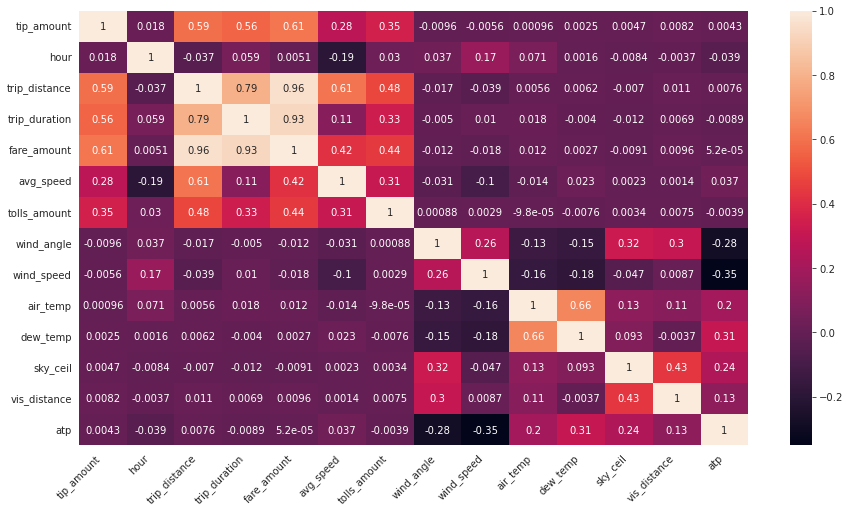

In [24]:
f1, axs = plt.subplots(figsize=(15, 8))
sns.heatmap(numeric_sample_pdf.corr(), annot = True)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, horizontalalignment='right')

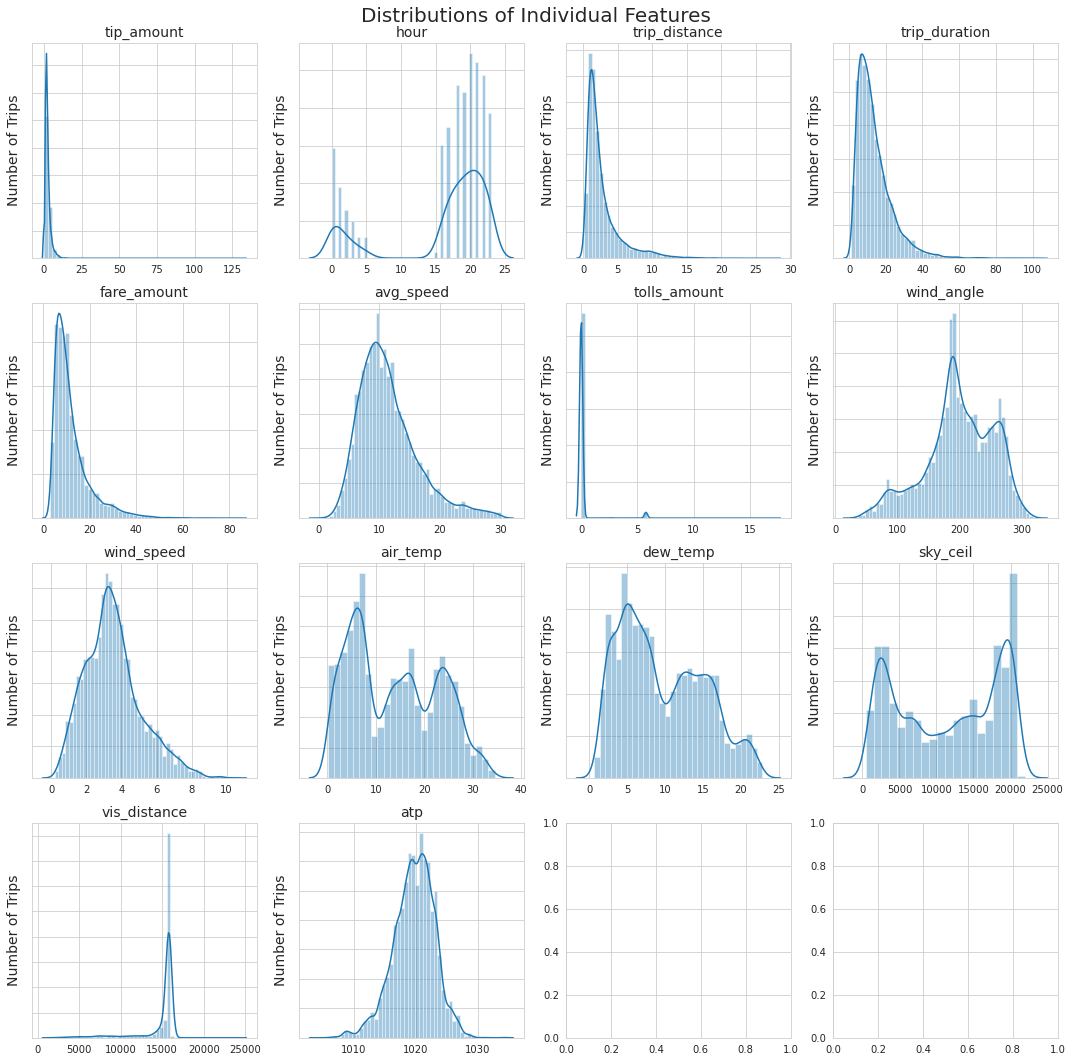

In [30]:
fig, axs = plt.subplots(4, 4, figsize = (15, 15))
labels = ['tip_amount', 'hour','trip_distance',
          'trip_duration', 'fare_amount', 'avg_speed', 'tolls_amount', 
          'wind_angle', 'wind_speed', 'air_temp', 'dew_temp', 
          'sky_ceil', 'vis_distance', 'atp']

count = 0
for i in range(4):
    for j in range(4):
        if count < len(labels):
            sns.distplot(x = numeric_sample_pdf[labels[count]], ax = axs[i, j])
            axs[i, j].set_title(labels[count], fontsize = 14)
            axs[i, j].set_yticklabels([])
            axs[i, j].set_ylabel("Number of Trips", fontsize = 14)
        count += 1
fig.suptitle('Distributions of Individual Features', fontsize = 20)
fig.tight_layout()
fig.savefig("../plots/distribution.png")

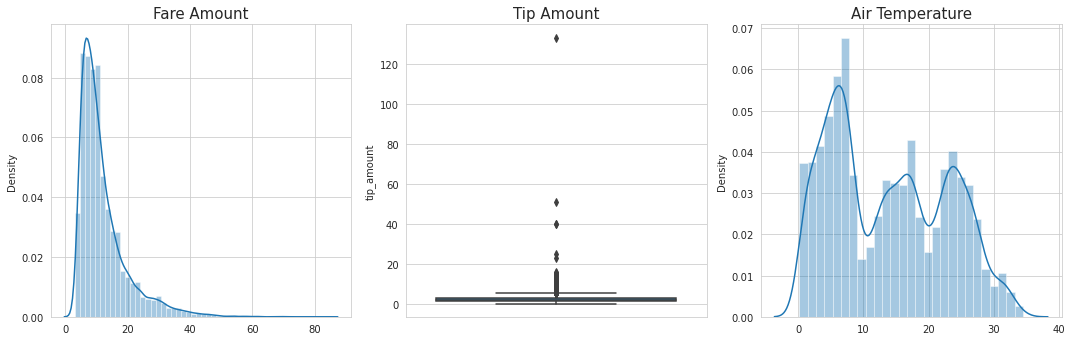

In [32]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize = (15, 5))
sns.distplot(x = numeric_sample_pdf['fare_amount'], ax = axis1)
sns.boxplot(y = numeric_sample_pdf['tip_amount'], ax = axis2)
sns.distplot(x = numeric_sample_pdf['air_temp'], ax = axis3)

fig.suptitle("", fontsize=18)

axis1.set_title('Fare Amount', fontsize = 15)
axis2.set_title('Tip Amount', fontsize = 15)
axis3.set_title('Air Temperature', fontsize = 15)
fig.tight_layout()

fig.savefig("../plots/two-highest-correlation.png")